# Backpropagation in Multilayer Neural Networks

### Goals: 
- Diving deep: implement a real gradient descent in `Numpy`

### Dataset:
- Similar as first Lab - Digits: 10 class handwritten digits
- [sklearn.datasets.load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

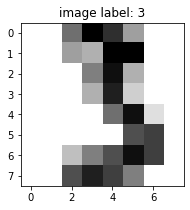

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- Normalization
- Train / test split

In [7]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(scaler.mean_)
# print(scaler.scale_)

In [8]:
X_train.shape

(1527, 64)

In [9]:
X_train.dtype

dtype('float32')

In [10]:
X_test.shape

(270, 64)

In [12]:
y_train.shape

(1527,)

In [13]:
y_train.dtype

dtype('int32')

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement a simple forward model with no hidden layer (equivalent to a logistic regression):
note: shape, transpose of W with regards to course
$y = softmax(\mathbf{W} \dot x + b)$

- Build a predict function which returns the most probable class given an input $x$

- Build an accuracy function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

- Build a grad function which computes $\frac{d}{dW} -\log(softmax(W \dot x + b))$ for an $x$ and its corresponding expected output $y_{true}$ ; check that the gradients are well defined

- Build a train function which uses the grad function output to update $\mathbf{W}$ and $b$


### One-hot encoding for class label data

First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to keras' `to_categorical`):

In [14]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [15]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [16]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [39]:
def softmax(X):
    X = np.exp(X)
    X /= np.sum(X,-1,keepdims=True)
    return X

Make sure that this works one vector at a time (and check that the components sum to one):

In [40]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


Note that a naive implementation of softmax might not be able process a batch of activations in a single call:

In [41]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Here is a way to implement softmax that works both for an individual vector of activations and for a batch of activation vectors at once:

In [42]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)


print("softmax of a single vector:")
print(softmax([10, 2, -3]))

softmax of a single vector:
[9.99662391e-01 3.35349373e-04 2.25956630e-06]


Probabilities should sum to 1:

In [43]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [44]:
print("sotfmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

sotfmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [45]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Implement a function that given the true one-hot encoded class `Y_true` and and some predicted probabilities `Y_pred` returns the negative log likelihood.

In [56]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    
    likelihood = np.sum(Y_true*Y_pred)
    nll = -np.log(likelihood)
    return nll


# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


Check that the nll of a very confident yet bad prediction is a much higher positive number:

In [57]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [63]:
def nll(Y_true, Y_pred):
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)

    likelihood = np.sum(Y_true*Y_pred,-1,keepdims=True)
    nll = -np.log(likelihood)
    return np.mean(nll)

In [64]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.00335011195116715


Let us now study the following linear model trainable by SGD, **one sample at a time**.

In [65]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        # Traditional SGD update without momentum
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]      
        
    def loss(self, x, y):
        return nll(one_hot(self.output_size, y), self.forward(x))

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [67]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 2.2639, train acc: 0.156, test acc: 0.144


Evaluate the randomly initialized model on the first example:

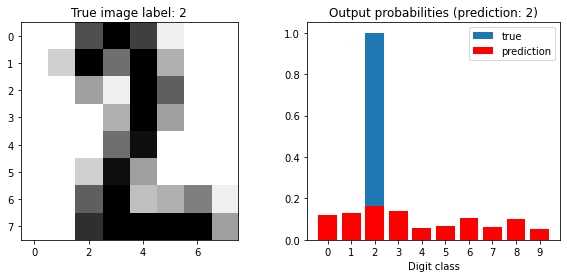

In [68]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx]).reshape(8, 8), cmap=plt.cm.gray_r,
               interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
plot_prediction(lr, sample_idx=0)

In [69]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

Update #0, train loss: 2.2443, train acc: 0.172, test acc: 0.159
Update #100, train loss: 1.2776, train acc: 0.671, test acc: 0.707
Update #200, train loss: 0.8445, train acc: 0.858, test acc: 0.874
Update #300, train loss: 0.6259, train acc: 0.904, test acc: 0.911
Update #400, train loss: 0.5250, train acc: 0.904, test acc: 0.907
Update #500, train loss: 0.4558, train acc: 0.916, test acc: 0.915
Update #600, train loss: 0.3968, train acc: 0.925, test acc: 0.926
Update #700, train loss: 0.3599, train acc: 0.933, test acc: 0.941
Update #800, train loss: 0.3398, train acc: 0.940, test acc: 0.952
Update #900, train loss: 0.3156, train acc: 0.940, test acc: 0.952
Update #1000, train loss: 0.2957, train acc: 0.945, test acc: 0.948
Update #1100, train loss: 0.2786, train acc: 0.948, test acc: 0.948
Update #1200, train loss: 0.2684, train acc: 0.950, test acc: 0.952
Update #1300, train loss: 0.2585, train acc: 0.950, test acc: 0.937
Update #1400, train loss: 0.2444, train acc: 0.956, test acc

Evaluate the trained model on the first example:

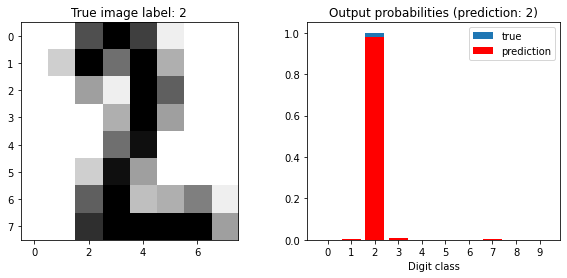

In [70]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

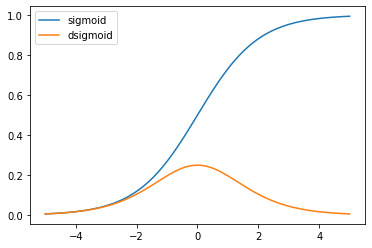

In [71]:
def sigmoid(X):
    return 1/(1+np.exp(-X))


def dsigmoid(X):
    return sigmoid(X)*(1-sigmoid(X))


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer with a sigmoid activation function:
  - $\mathbf{h} = sigmoid(\mathbf{W}^h \mathbf{x} + \mathbf{b^h})$
  - $\mathbf{y} = softmax(\mathbf{W}^o \mathbf{h} + \mathbf{b^o})$

- Notes: 
  - try to keep the code as similar as possible as the previous one;
  - `forward_keep_activations` is similar to forward, but also returns hidden activations and pre activations;

- Update the grad function to compute all gradients; check that the gradients are well defined;

- Implement the `train` and `loss` functions.

**Bonus**: reimplementing all from scratch only using the lecture slides but without looking at the solution of the `LogisticRegression` is an excellent exercise.

In [104]:
EPSILON = 1e-8


class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""
    
    def __init__(self, input_size, hidden_size, output_size):
        # TODO
        self.W_h = np.random.uniform(size=(input_size, hidden_size),high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size,high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        y, _, _ = self.forward_keep_activations(X)
        return y
    
    def forward_keep_activations(self, X):
        z_h = X.dot(self.W_h)+self.b_h
        h = sigmoid(z_h)
        y = softmax(h.dot(self.W_o)+self.b_o)
        return y, h, z_h
    
    def loss(self, X, y):
        return nll(one_hot(self.output_size,y),self.forward(X))

    def grad_loss(self, x, y_true):
        y_pred, h, z_h = self.forward_keep_activations(x)
        dnll_output = y_pred - one_hot(self.output_size, y_true)
        dnll_hidden = np.multiply(dsigmoid(z_h),self.W_o.dot(dnll_output))
        grad_W_o = np.outer(h,dnll_output)
        grad_b_o = dnll_output
        grad_W_h = np.outer(x,dnll_hidden)
        grad_b_h = dnll_hidden
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x,y)
        self.W_h -= learning_rate*grads["W_h"]
        self.b_h -= learning_rate*grads["b_h"]
        self.W_o -= learning_rate*grads["W_o"]
        self.b_o -= learning_rate*grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [105]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [106]:
model.loss(X_train, y_train)

2.301213726793204

In [107]:
model.accuracy(X_train, y_train)

0.10870988867059594

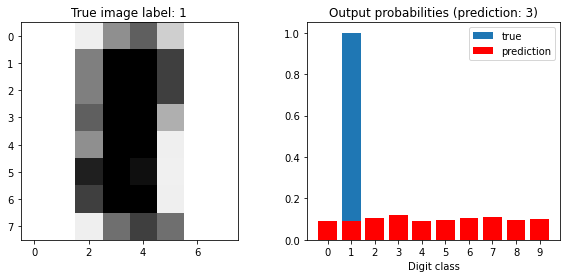

In [108]:
plot_prediction(model, sample_idx=5)

In [109]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 2.30121, train acc: 0.109, test acc: 0.063
Epoch #1, train loss: 0.33579, train acc: 0.912, test acc: 0.885
Epoch #2, train loss: 0.16836, train acc: 0.963, test acc: 0.919
Epoch #3, train loss: 0.11249, train acc: 0.976, test acc: 0.930
Epoch #4, train loss: 0.08346, train acc: 0.984, test acc: 0.933
Epoch #5, train loss: 0.06456, train acc: 0.989, test acc: 0.941
Epoch #6, train loss: 0.05378, train acc: 0.993, test acc: 0.952
Epoch #7, train loss: 0.05249, train acc: 0.993, test acc: 0.948
Epoch #8, train loss: 0.04118, train acc: 0.995, test acc: 0.948
Epoch #9, train loss: 0.03391, train acc: 0.996, test acc: 0.948
Epoch #10, train loss: 0.02980, train acc: 0.995, test acc: 0.948
Epoch #11, train loss: 0.02646, train acc: 0.997, test acc: 0.948
Epoch #12, train loss: 0.02422, train acc: 0.998, test acc: 0.956
Epoch #13, train loss: 0.02161, train acc: 0.998, test acc: 0.956
Epoch #14, train loss: 0.01944, train acc: 0.999, test acc: 0.956
Epoch #15, train 

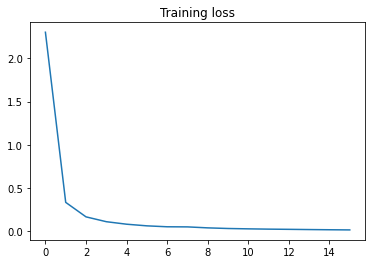

In [110]:
plt.plot(losses)
plt.title("Training loss");

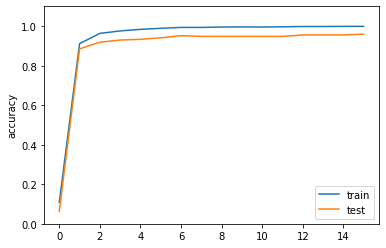

In [111]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

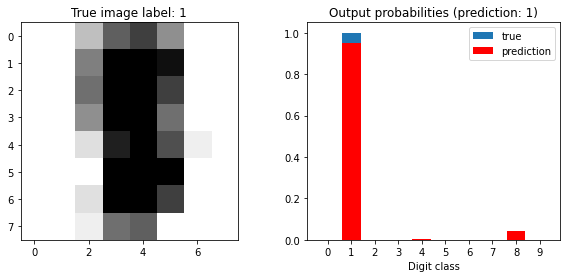

In [112]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

worst test losses: [2.42413155 2.59745909 4.41711944 6.38865566 9.22345016]


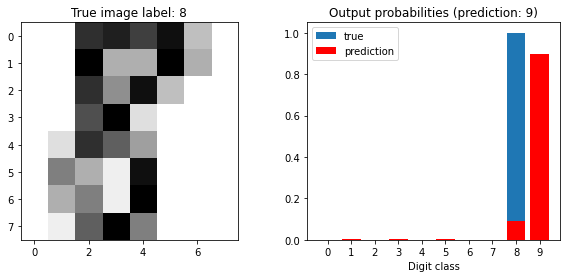

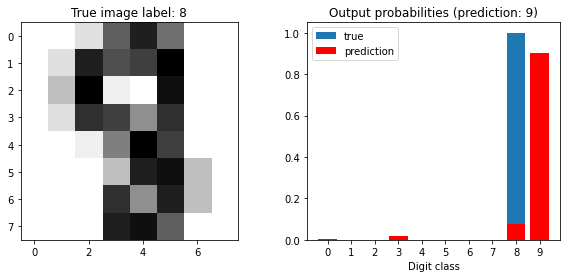

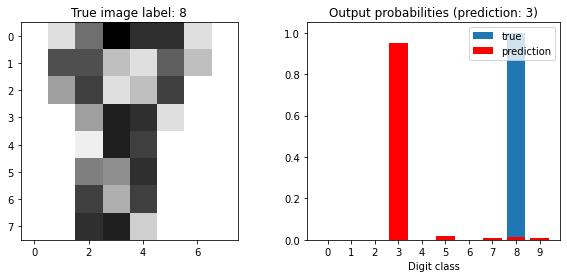

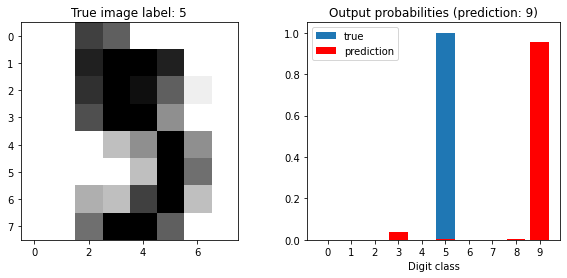

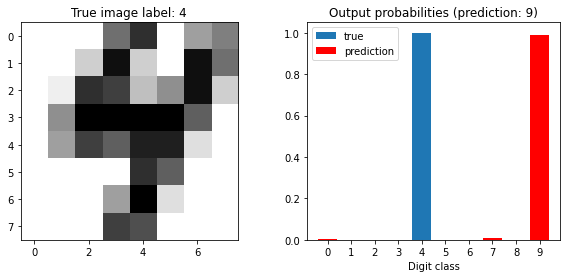

In [133]:
Y_pred = model.forward(X_test)
Y_true = one_hot(10,y_test)
Y_true = np.atleast_2d(Y_true)
Y_pred = np.atleast_2d(Y_pred)

likelihood = np.sum(Y_true*Y_pred,-1)
test_losses = -np.log(likelihood)

sorted_loss = np.argsort(test_losses)
worst = sorted_loss[-5:]
print("worst test losses:", test_losses[worst])
for idx in worst:
  plot_prediction(model, sample_idx=idx)

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer.


### Mini-batches

- The current implementations of `train` and `grad_loss` function currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of 32 samples at a time instead of one,
    - experiment with different sizes of batches,
    - monitor the norm of the average gradients on the full training set at the end of each epoch.


### Momentum

- Bonus: Implement momentum



## Homework assignments

- Watch the following video on [how to code a minimal deep learning framework](https://www.youtube.com/watch?v=o64FV-ez6Gw)

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("o64FV-ez6Gw")

- **Optional**: read the following blog post on Reverse-Mode Automatic Differentiation from start to section "A simple implementation in Python" included:

  https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation